In [1]:
import random

import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

# to play the audio files
from IPython.display import Audio
from pydub import AudioSegment
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint
import openpyxl
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow


In [2]:
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


In [3]:
# Path for CREMA-D dataset
# cremaD = "datasets/CremaD"
cremaD = "E:\EM/unsplittedDatasets\datasets\CremaD"

In [4]:
crema_directory_list = os.listdir(cremaD)
file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    # storing file emotions
    part = file.split('_')
    if part[2] == 'SAD':
        file_path.append(cremaD + "/" + file)
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_path.append(cremaD + "/" + file)
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        continue
        # file_emotion.append('disgust')
    elif part[2] == 'FEA':
        continue
        # file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_path.append(cremaD + "/" + file)
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_path.append(cremaD + "/" + file)
        file_emotion.append('neutral')
    else:
        continue
        # file_emotion.append('Unknown')

# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()
print(Crema_df.shape)


(4900, 2)


In [5]:
emotionCount = {}
for i in Crema_df.index:
    emotions = Crema_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 1271, 'happy': 1271, 'neutral': 1087, 'sad': 1271}


In [6]:
emotionCount = {'angry': 900, 'happy': 1087, 'neutral': 1087, 'sad': 950}

for i in Crema_df.index:
    emotions = Crema_df["Emotions"][i]
    if emotions in emotionCount:
        if emotionCount[emotions] > 0:
            emotionCount[emotions] -= 1
        else:
            Crema_df.drop(i, inplace=True)
print(Crema_df.shape)

(4024, 2)


In [7]:
# smallCount = min(emotionCount.values())
# print(smallCount)
# print(Crema_df.shape)

In [8]:
# counts = Crema_df['Emotions'].value_counts()
#
# # find the minimum count
# min_count = counts.min()
#
# # create a list to store the balanced dataframes
# balanced_dfs = []
#
# # iterate over the emotions
# for emotion in counts.index:
#     # subset the data for the current emotion to have the minimum count
#     balanced_df = Crema_df[Crema_df['Emotions'] == emotion].head(min_count)
#     balanced_dfs.append(balanced_df)
#
# # concatenate all the balanced dataframes into one final dataframe
# final_df = pd.concat(balanced_dfs)
# Crema_df = final_df
# Crema_df


In [9]:
emotionCount = {}
for i in Crema_df.index:
    emotions = Crema_df["Emotions"][i]
    if emotions in emotionCount:
        emotionCount[emotions]+=1
    else:
        emotionCount[emotions]=1
emotionCount = dict(sorted(emotionCount.items(), key=lambda x: x[0]))
print(emotionCount)

{'angry': 900, 'happy': 1087, 'neutral': 1087, 'sad': 950}


In [10]:
data_path = pd.concat([Crema_df], axis=0)
data_path.to_csv("data_path_C.csv", index=False)
data_path.head()
data_path.shape

(4024, 2)

In [11]:
emotionList = pd.read_csv("data_path_C.csv")
emotions = emotionList["Emotions"]
emotionCount = {}
for item in emotions:
    if item in emotionCount:
        emotionCount[item] += 1
    else:
        emotionCount[item] = 1
emotionCount=dict(sorted(emotionCount.items(), key=lambda x:x[0]))
print(emotionCount)

{'angry': 900, 'happy': 1087, 'neutral': 1087, 'sad': 950}


['angry', 'happy', 'neutral', 'sad']

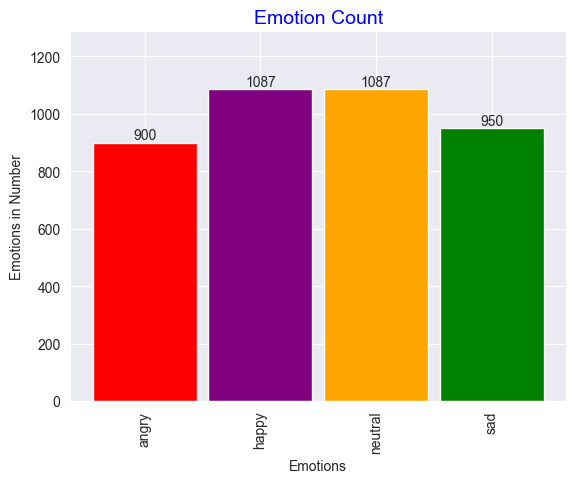

In [12]:
plt.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt.xlabel("Emotions")
plt.xticks(rotation=90)
plt.ylabel("Emotions in Number")
plt.title("Emotion Count", size=14, color="Blue")
plt.ylim([0, max(emotionCount.values()) + 200])
lst = []
for item in emotionCount:
    plt.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")
sorted(emotionCount)

In [13]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()


def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
    # librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()


In [14]:
def noise(data):
    noise_amp = 0.035 * np.random.uniform() * np.amax(data)
    data = data + noise_amp * np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high=5) * 1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

def volumeAdd(data):
    songData = AudioSegment.from_wav(data)
    print("sing", songData)
    songDataSamples = np.array(songData.get_array_of_samples())
    songHighVolumed = songDataSamples - 10000.0
    print(songHighVolumed)
    return songHighVolumed


E:\EM/unsplittedDatasets\datasets\CremaD/1001_DFA_HAP_XX.wav


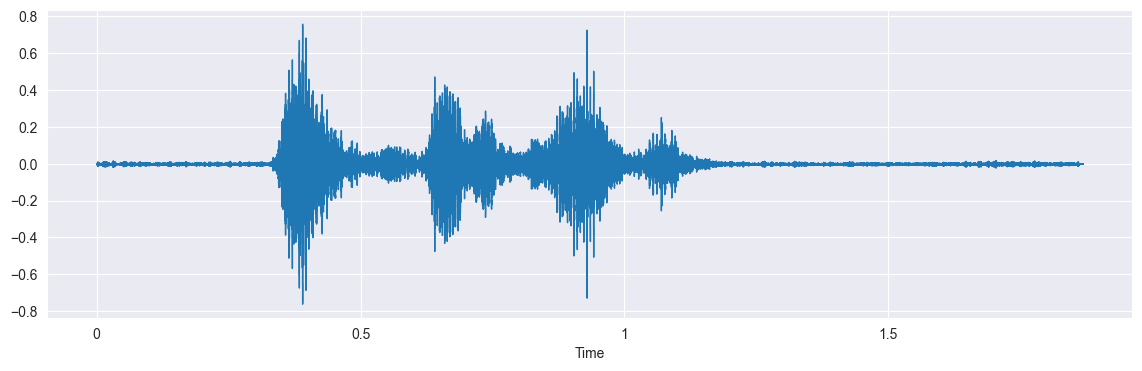

In [15]:
# taking any example and checking for techniques.
path = np.array(data_path.Path)[1]
print(path)
data, sample_rate = librosa.load(path)
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y=data, sr=sample_rate)
Audio(path)


In [16]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result = np.hstack((result, zcr))  # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(
        S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft))  # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc))  # stacking horizontally

    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms))  # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(
        y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel))  # stacking horizontally

    return result


def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)

    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)

    # data with noise
    # noise_data = noise(data)
    # res2 = extract_features(noise_data)
    # result = np.vstack((result, res2))  # stacking vertically

    # # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3))  # stacking vertically

    return result


In [17]:
X, Y = [], []
for path, emotion in zip(data_path.Path, data_path.Emotions):
    try:
        feature = get_features(path)
    except:
        print(path)
        print(emotion)
    for ele in feature:
        try:
            X.append(ele)
            # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
            Y.append(emotion)
        except:
            print(ele)

In [18]:
len(X), len(Y), data_path.Path.shape

(8048, 8048, (4024,))

In [19]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_excel('features_C.xlsx', index=False)
X = Features.iloc[:, :-1].values
Y = Features['labels'].values
y_labels = Y


In [20]:
features_df = pd.read_excel("features_C.xlsx")

In [21]:
featuresofit = np.asarray(features_df.iloc[:,:-1].values)
X = featuresofit
labelofit = np.asarray(features_df['labels'])
Y = labelofit

In [22]:
emotionsfromFeatures = features_df['labels']
emotionCountfromFeatures = {}
for item in emotionsfromFeatures:
    if item in emotionCountfromFeatures:
        emotionCountfromFeatures[item] += 1
    else:
        emotionCountfromFeatures[item] = 1
print(emotionCountfromFeatures)

{'angry': 1800, 'happy': 2174, 'neutral': 2174, 'sad': 1900}


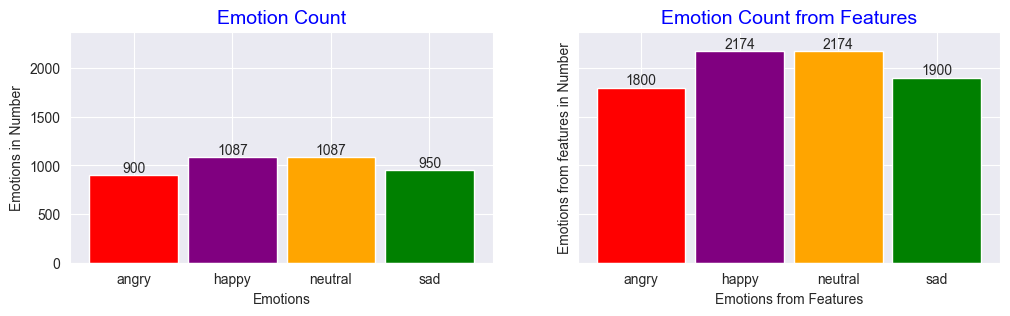

In [23]:
fig, (plt1,plt2) = plt.subplots(1,2,sharey=True, figsize=(12,3))
plt1.bar(emotionCount.keys(), emotionCount.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt1.set_xlabel("Emotions")
plt1.set_ylabel("Emotions in Number")
plt1.set_title("Emotion Count", size=14, color="Blue")
plt1.set_ylim([0, max(emotionCount.values()) + 200])
# lst = []
for item in emotionCount:
    plt1.text(item, emotionCount[item],
             emotionCount[item], ha="center", va="bottom")

plt2.bar(emotionCountfromFeatures.keys(), emotionCountfromFeatures.values(), width=0.9, align="center",
        color=["red","purple","orange","green","cyan","blue","yellow"])
plt2.set_xlabel("Emotions from Features")
plt2.set_ylabel("Emotions from features in Number")
plt2.set_title("Emotion Count from Features", size=14, color="Blue")
plt2.set_ylim([0, max(emotionCountfromFeatures.values()) + 200])
# lst = []
for item in emotionCountfromFeatures:
    plt2.text(item, emotionCountfromFeatures[item],
             emotionCountfromFeatures[item], ha="center", va="bottom")
# plt2.subplots(nrows=1,ncols=2)

In [24]:
# print(Y)
x_train, x_test, y_train, y_test = train_test_split(
    X, Y, random_state=0, test_size=0.1, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape
# pd.DataFrame(Y)

((7243, 162), (7243,), (805, 162), (805,))

In [25]:
from sklearn.preprocessing import MinMaxScaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((7243, 162), (7243,), (805, 162), (805,))

In [26]:
kernelchoice = ["rbf"]
C_choice = [150,200,250,300,350]
import random

In [27]:
from sklearn import svm
from sklearn.metrics import accuracy_score
classifier = svm.SVC(kernel='rbf', gamma="auto", C=10)
classifier.fit(x_train, y_train)
y_predict = classifier.predict(x_test)
accuracyPercent = accuracy_score(y_test, y_predict) * 100
print("Accuracy"+ "  :  " + str(accuracyPercent))

Accuracy  :  68.19875776397517


In [28]:
print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

       angry       0.81      0.69      0.74       180
       happy       0.65      0.67      0.66       220
     neutral       0.62      0.70      0.66       221
         sad       0.70      0.67      0.69       184

    accuracy                           0.68       805
   macro avg       0.69      0.68      0.69       805
weighted avg       0.69      0.68      0.68       805



In [29]:
yPred = classifier.predict(x_train)
print(accuracy_score(y_train, yPred))

0.8062957338119564
